# LABORATORUL 3

In [131]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pyod
from pyod.models.dif import DIF
from pyod.models.loda import LODA
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.datasets import make_blobs
from pyod.models.iforest import IForest



## Exercise 1

### 1

In [7]:
std_norm_dataset: np.ndarray = None
std_norm_labels: np.ndarray = None

std_norm_dataset, std_norm_labels = sklearn.datasets.make_blobs(
    n_samples = 500,
    n_features = 2,
    centers=[(0,0)],
    cluster_std = 1.0
)


Dataset shape: (500, 2)
Labels shape: (500,)


### 2


In [12]:
# we'll have a vector V with 5 unit-length vectors
num_vectors: int = 5
cov_matrix = np.array([[1, 0], [0, 1]])
V = np.random.multivariate_normal(mean=[0, 0], cov=cov_matrix, size=num_vectors)
V = V / np.linalg.norm(V, axis=1, keepdims=True)


projected_values = []
for i in range(num_vectors):
    vi_projected = []
    for j in range(std_norm_dataset.shape[0]):
        projected_value = np.dot(std_norm_dataset[j], V[i])
        vi_projected.append(projected_value)
    projected_values.append(vi_projected)



histograms = []
bin_edges_list = []

for p in projected_values:
    data_min, data_max = np.min(p), np.max(p)
    extended_range = (data_min - 1, data_max + 1)

    counts, bin_edges = np.histogram(p, bins=20, range=extended_range)
    probabilities = counts / np.sum(counts)

    histograms.append(probabilities)
    bin_edges_list.append(bin_edges)



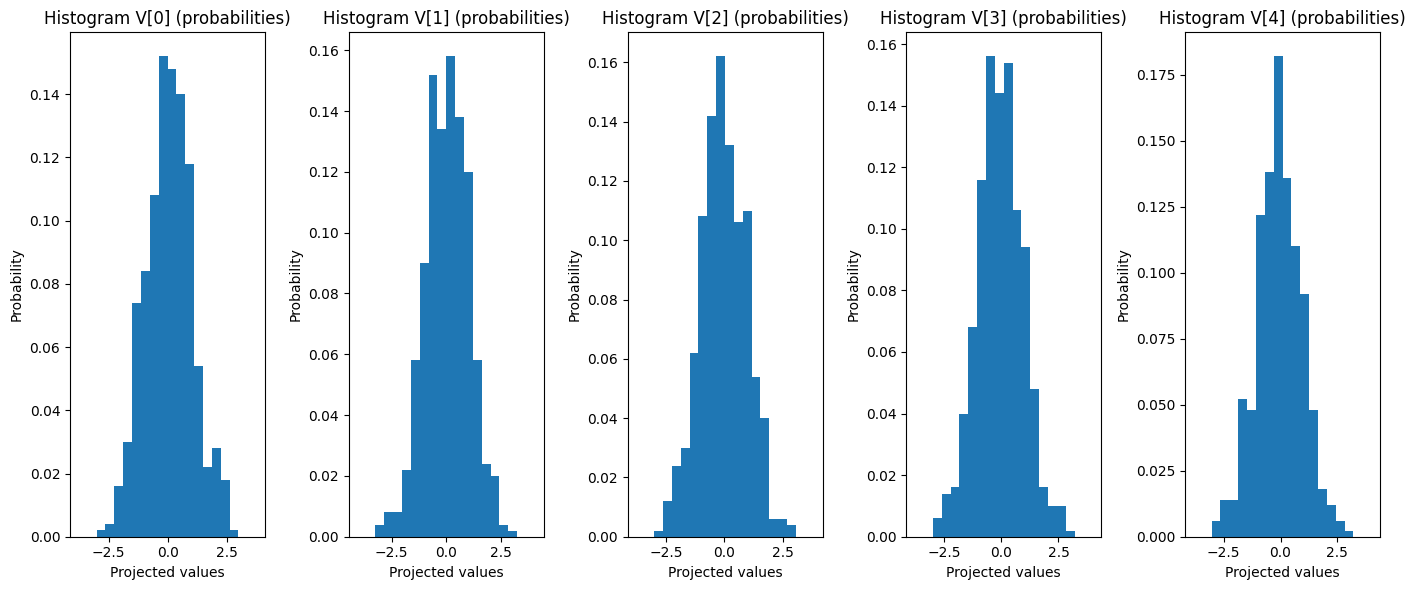

In [19]:
plt.figure(figsize=(14, 6))

for i in range(num_vectors):
    probabilities = histograms[i]
    bin_edges = bin_edges_list[i]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.subplot(1, num_vectors, i+1)
    plt.bar(bin_centers, probabilities, width=(bin_edges[1] - bin_edges[0]))
    plt.title(f"Histogram V[{i}] (probabilities)")
    plt.xlabel("Projected values")
    plt.ylabel("Probability")

plt.tight_layout()
plt.show()


In [11]:
def anomaly_score(sample: np.ndarray) -> float:
    scores = []

    for i in range(num_vectors):
        proj = np.dot(sample, V[i])
        probabilities = histograms[i]
        bin_edges = bin_edges_list[i]

        bin_index = np.searchsorted(bin_edges, proj, side="right") - 1

        if bin_index < 0 or bin_index >= len(probabilities):
            scores.append(0.0)
        else:
            scores.append(probabilities[bin_index])
    return np.mean(scores)




In [20]:
# TEST
print("Score normal:", anomaly_score(std_norm_dataset[0]))
print("Score for anomaly:", anomaly_score(np.array([10.0, 10.0])))


Score normal: 0.1332
Score for anomaly: 0.0212


### 3

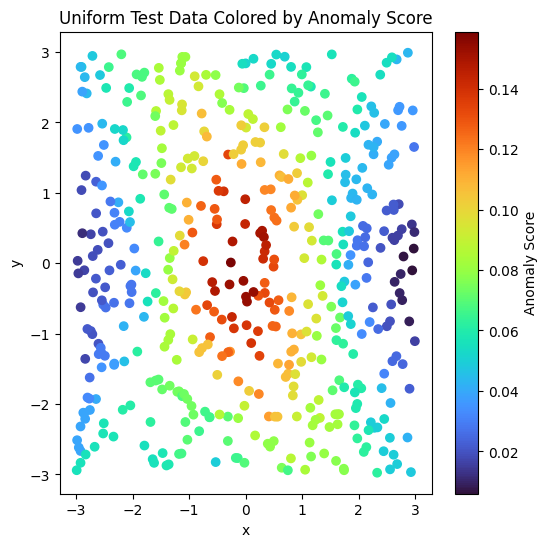

In [22]:
test_dataset = np.random.uniform(low=-3, high=3, size=(500, 2))

test_scores = np.array([anomaly_score(x) for x in test_dataset])

plt.figure(figsize=(6, 6))
scatter = plt.scatter(
    test_dataset[:, 0],
    test_dataset[:, 1],
    c=test_scores,
    cmap="turbo"
)
plt.colorbar(scatter, label="Anomaly Score")
plt.title("Uniform Test Data Colored by Anomaly Score")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


### 4


In [24]:
def rebuild_histograms(num_bins: int):
    global histograms, bin_edges_list
    histograms = []
    bin_edges_list = []

    for p in projected_values:
        data_min, data_max = np.min(p), np.max(p)
        extended_range = (data_min - 1, data_max + 1)

        counts, bin_edges = np.histogram(p, bins=num_bins, range=extended_range)
        probabilities = counts / np.sum(counts)

        histograms.append(probabilities)
        bin_edges_list.append(bin_edges)


test_dataset = np.random.uniform(low=-3, high=3, size=(500, 2))


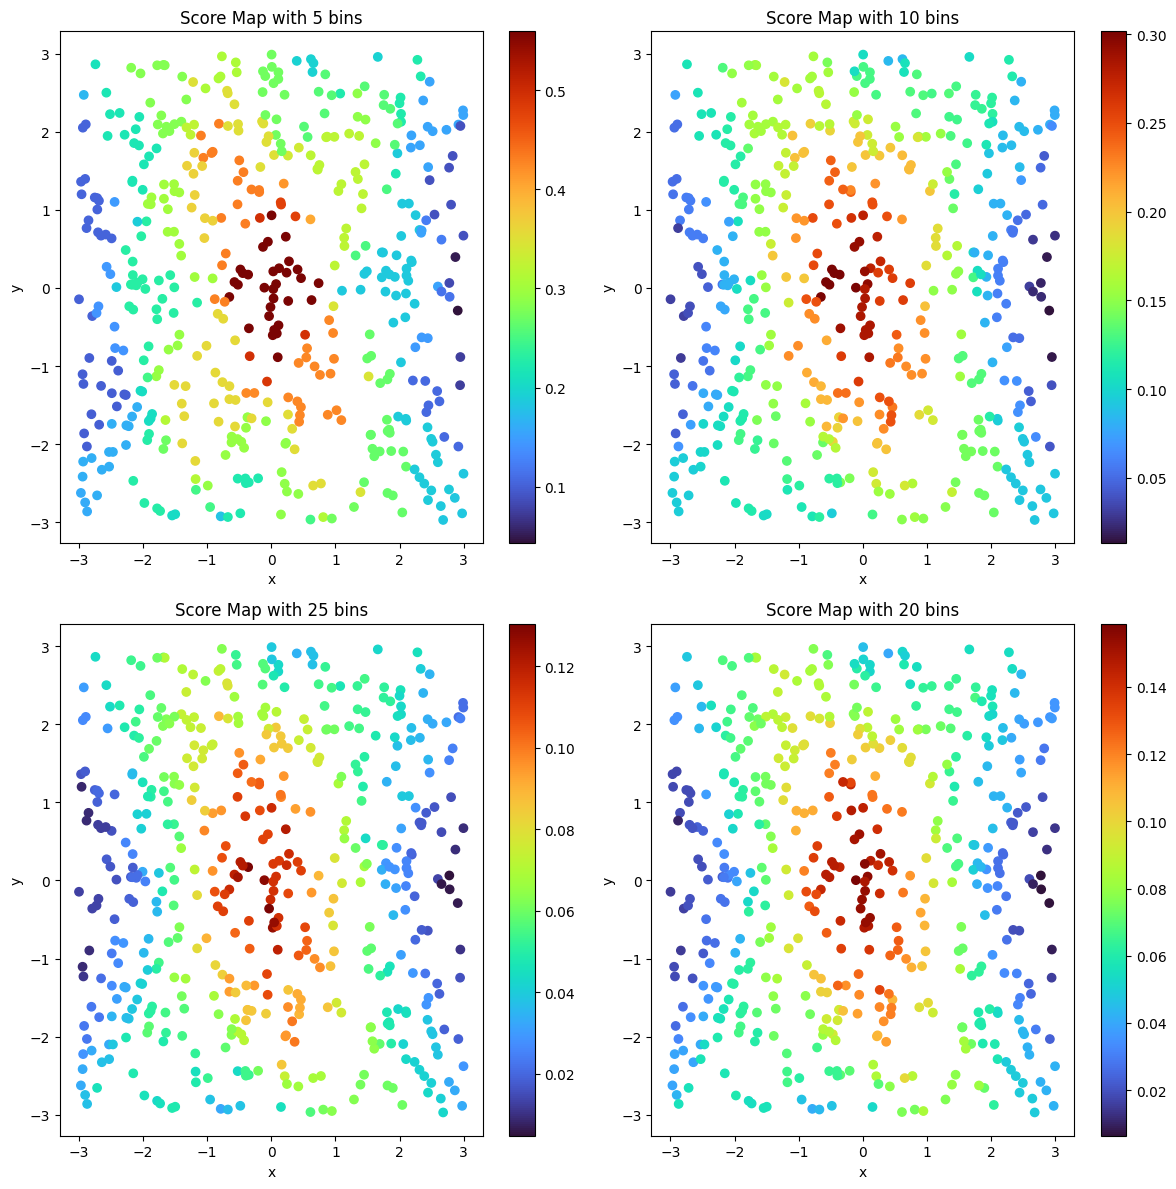

In [30]:
bin_list = [5, 10, 25, 20]

plt.figure(figsize=(12, 12))

for idx, b in enumerate(bin_list):
    rebuild_histograms(b)
    test_scores = np.array([anomaly_score(x) for x in test_dataset])

    plt.subplot(2, 2, idx+1)
    scatter = plt.scatter(test_dataset[:, 0], test_dataset[:, 1], c=test_scores, cmap="turbo")
    plt.colorbar(scatter)
    plt.title(f"Score Map with {b} bins")
    plt.xlabel("x")
    plt.ylabel("y")

plt.tight_layout()
plt.show()


## Exercise 2

### 1

In [149]:
cluster_dataset: np.ndarray = None
cluster_labels: np.ndarray = None

cluster_dataset, cluster_labels = sklearn.datasets.make_blobs(
    n_samples = 1000,
    n_features = 2,
    centers = [(10, 0), (0, 10)],
    cluster_std = 1.0
)

### 2

In [150]:
model = pyod.models.iforest.IForest(contamination=0.02)
model.fit(cluster_dataset)

test_data = np.random.uniform(low=-10, high=20, size=(1000, 2))
test_predictions = model.predict(test_data)

num_outliers = np.sum(test_predictions == 0)
print("No outliers:", num_outliers)
print(np.unique(test_predictions, return_counts=True))

No outliers: 82
(array([0, 1]), array([ 82, 918], dtype=int64))


### 3

In [151]:

anomaly_scores_if = model.decision_function(test_data)


### 4

In [152]:
model = DIF(contamination=0.02)
model.fit(cluster_dataset)

test_data = np.random.uniform(low=-10, high=20, size=(1000, 2))

anomaly_scores_dif = model.decision_function(test_data)
test_predictions = model.predict(test_data)

num_outliers = np.sum(test_predictions == 1)


In [153]:
model = LODA(contamination=0.02)
model.fit(cluster_dataset)

test_data = np.random.uniform(low=-10, high=20, size=(1000, 2))

anomaly_scores_loda = model.decision_function(test_data)

test_predictions = model.predict(test_data)

num_outliers = np.sum(test_predictions == 1)
print("No. outliers", num_outliers)


No. outliers 248


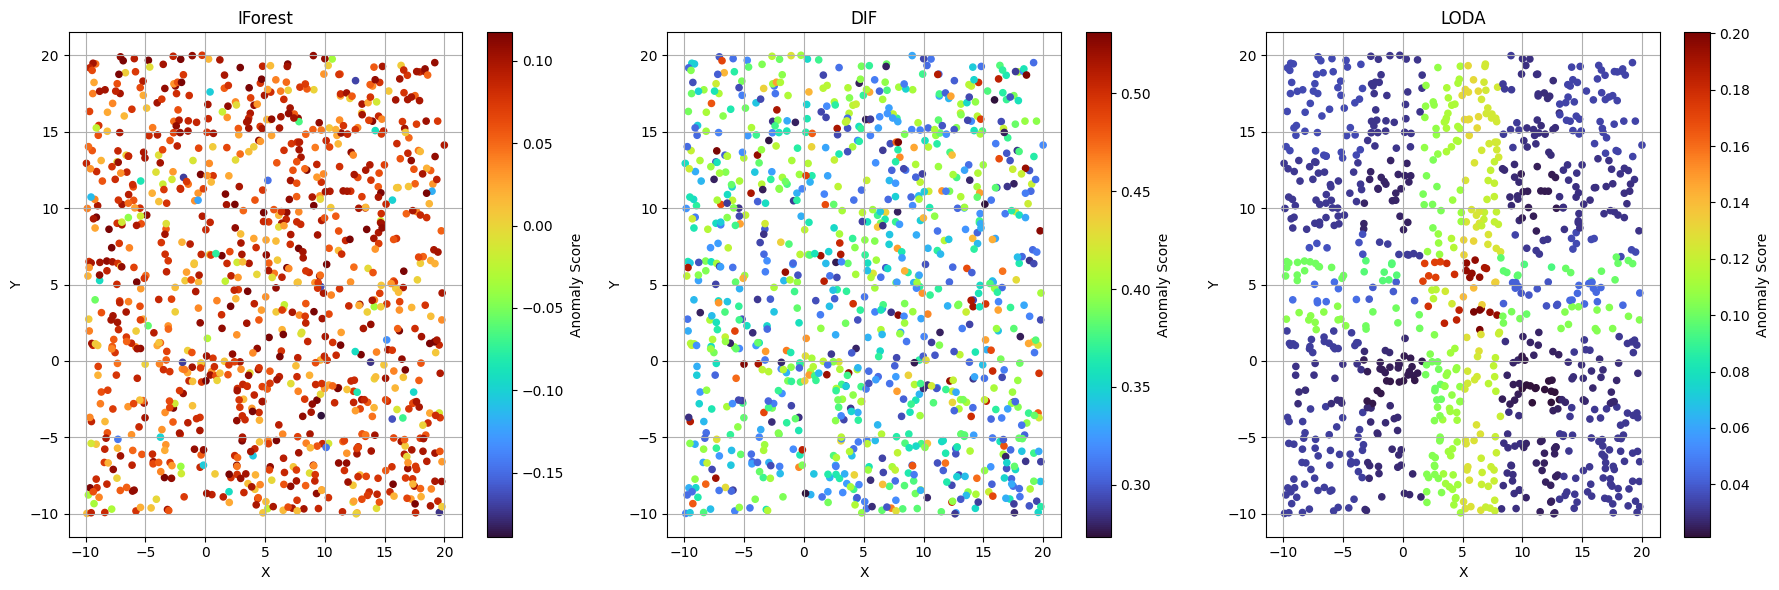

In [155]:
plt.figure(figsize=(18, 6))

# IForest
plt.subplot(1, 3, 1)
scatter = plt.scatter(test_data[:, 0], test_data[:, 1],
                      c=anomaly_scores_if, cmap='turbo', s=20)
plt.title("IForest")
plt.xlabel("X"); plt.ylabel("Y"); plt.grid(True)
plt.colorbar(scatter, label="Anomaly Score")

# DIF
plt.subplot(1, 3, 2)
scatter = plt.scatter(test_data[:, 0], test_data[:, 1],
                      c=anomaly_scores_dif, cmap='turbo', s=20)
plt.title("DIF")
plt.xlabel("X"); plt.ylabel("Y"); plt.grid(True)
plt.colorbar(scatter, label="Anomaly Score")

# LODA
plt.subplot(1, 3, 3)
scatter = plt.scatter(test_data[:, 0], test_data[:, 1],
                      c=anomaly_scores_loda, cmap='turbo', s=20)
plt.title("LODA")
plt.xlabel("X"); plt.ylabel("Y"); plt.grid(True)
plt.colorbar(scatter, label="Anomaly Score")

plt.tight_layout()
plt.show()


### 5

In [ ]:
architectures = [
    ( "DIF (256,256)",   (256, 256) ),
    ( "DIF (256,128)",   (64, 64) ),
    ( "DIF (128,64)",  (128, 64) )
]

plt.figure(figsize=(18, 5))

for i, (label, neurons) in enumerate(architectures, start=1):
    model = DIF(hidden_neurons=neurons, contamination=0.02)
    model.fit(cluster_dataset)

    anomaly_scores = model.decision_function(test_data)
    test_predictions = model.predict(test_data)

    num_outliers = np.sum(test_predictions == 1)
    print(f"{label} - Number of outliers: {num_outliers}")

    plt.subplot(1, 3, i)
    scatter = plt.scatter(test_data[:, 0], test_data[:, 1],
                          c=anomaly_scores, cmap='turbo', s=20)
    plt.title(label)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)

plt.colorbar(scatter, ax=plt.gca(), label="Anomaly Score")
plt.suptitle("DIF", fontsize=14)
plt.show()

LODA (n_bins=10) - Number of outliers: 149
LODA (n_bins=30) - Number of outliers: 661
LODA (n_bins=60) - Number of outliers: 344


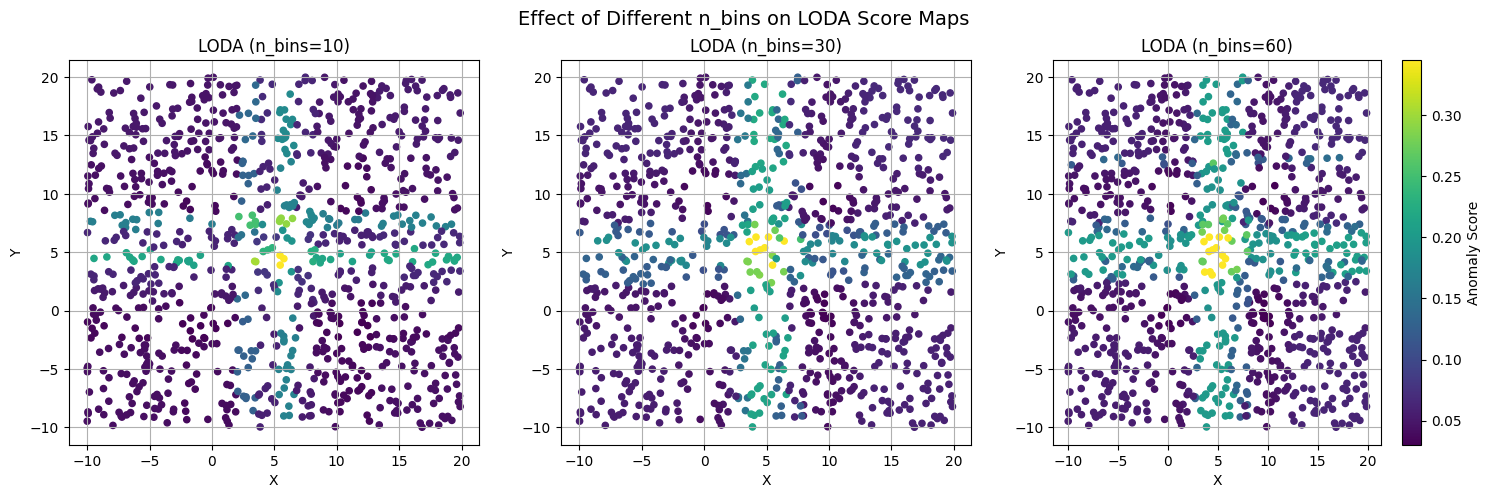

In [93]:
bin_settings = [10, 30, 60]

plt.figure(figsize=(18, 5))

for i, bins in enumerate(bin_settings, start=1):
    model = LODA(contamination=0.02, n_bins=bins)
    model.fit(cluster_dataset)

    anomaly_scores = model.decision_function(test_data)
    test_predictions = model.predict(test_data)
    num_outliers = np.sum(test_predictions == 1)

    print(f"LODA (n_bins={bins}) - Number of outliers:", num_outliers)

    plt.subplot(1, 3, i)
    scatter = plt.scatter(test_data[:, 0], test_data[:, 1],
                          c=anomaly_scores, cmap='turbo', s=20)
    plt.title(f"LODA (n_bins={bins})")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)

plt.colorbar(scatter, ax=plt.gca(), label="Anomaly Score")
plt.suptitle("LODA", fontsize=14)
plt.show()

### 6

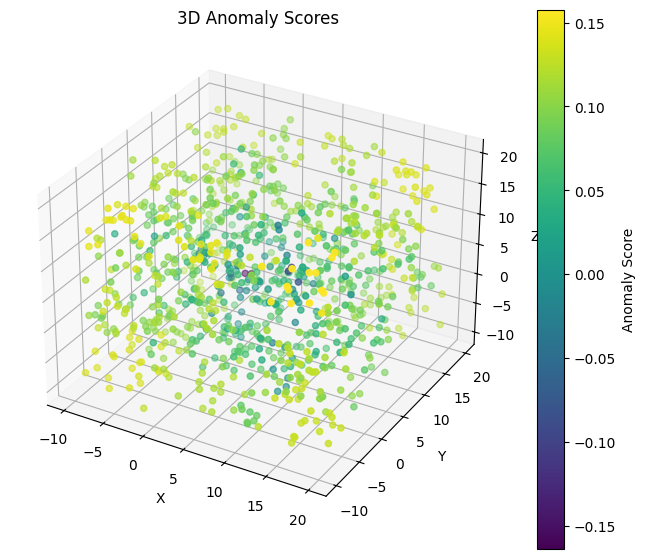

In [136]:

cluster_dataset, cluster_labels = make_blobs(
    n_samples=1000,
    n_features=3,
    centers=[(0, 10, 0), (10, 0, 10)],
    cluster_std=1.0,
    random_state=42
)

model = IForest(contamination=0.02)
model.fit(cluster_dataset)

test_data = np.random.uniform(low=-10, high=20, size=(1000, 3))

anomaly_scores = model.decision_function(test_data)
test_predictions = model.predict(test_data)

num_outliers = np.sum(test_predictions == 1)

fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(test_data[:, 0], test_data[:, 1], test_data[:, 2],
               c=anomaly_scores, cmap='turbo', s=20)

fig.colorbar(p, label="Anomaly Score")
ax.set_title("3D Anomaly Scores")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

## Exercise 3


### 1

In [99]:
data = scipy.io.loadmat("shuttle.mat")

X = data['X']
y = data['y'].ravel()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Labels distribution in train:", np.unique(y_train, return_counts=True))

Training set shape: (29458, 9)
Test set shape: (19639, 9)
Labels distribution in train: (array([0, 1], dtype=uint8), array([27351,  2107], dtype=int64))


### 2


IForest

In [101]:
def evaluate_iforest(seed):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.40, random_state=seed, stratify=y
    )
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = IForest(random_state=seed)
    model.fit(X_train)

    y_pred = model.predict(X_test)
    y_score = model.decision_function(X_test)

    ba = balanced_accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_score)
    return ba, auc


In [104]:
BA_iforest = []
AUC_iforest = []

for seed in range(10):
    ba, auc = evaluate_iforest(seed)
    BA_iforest.append(ba)
    AUC_iforest.append(auc)

print(f"Mean Balanced Accuracy: {np.mean(BA_iforest):.4f}")
print(f"Mean ROC AUC:          {np.mean(AUC_iforest):.4f}")



Mean Balanced Accuracy: 0.9762
Mean ROC AUC:          0.9969


In [105]:
def evaluate_loda(seed):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.40, random_state=seed, stratify=y
    )
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = LODA()
    model.fit(X_train)

    y_pred = model.predict(X_test)
    y_score = model.decision_function(X_test)

    ba = balanced_accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_score)
    return ba, auc


In [106]:
BA_loda = []
AUC_loda = []

for seed in range(10):
    ba, auc = evaluate_loda(seed)
    BA_loda.append(ba)
    AUC_loda.append(auc)

print(f"Mean Balanced Accuracy: {np.mean(BA_loda):.4f}")
print(f"Mean ROC AUC:          {np.mean(AUC_loda):.4f}")


Mean Balanced Accuracy: 0.7381
Mean ROC AUC:          0.7195


In [128]:
data = scipy.io.loadmat("shuttle.mat")
X = data["X"]
y = data["y"].ravel()

y = (y != 1).astype(int)

print("Data loaded.")
print("X shape:", X.shape)
print("Label distribution:", np.unique(y, return_counts=True))

def evaluate_dif(seed):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.40, random_state=seed, stratify=y
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = DIF(
        n_estimators=20,
        random_state=seed
    )

    model.fit(X_train)

    y_pred = model.predict(X_test)
    y_score = model.decision_function(X_test)

    ba = balanced_accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_score)
    return ba, auc


Data loaded.
X shape: (49097, 9)
Label distribution: (array([0, 1]), array([ 3511, 45586], dtype=int64))
